# Week 12

VGG13 for CIFAR10

In [79]:
model = VGG13()

train(hyper_param_dict, model)

0th epoch starting.
Epoch [1] Loss: 2.2996
[Test set] Average loss: 0.0092, Accuracy: 1241/10000 (12.41%)

Time ellapsed in training is: 23.92855215072632
save dir : /home/lagoon/Project/ml_albert_no/Result/VGG13.v1/19_5_14


In [70]:
import torch
import torch.nn as nn
import math
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import datetime
import pickle
import os

#hyper parameter 

hyper_param_dict = { 
                'project' : 'VGG13.v1',
                'epochs' : 1,
                'batch' : 256, 
                'lr' : 0.05,
                'optimizer': 'SGD',
                'momentum' : 0.9,   
                'beta1' : 0.9,
                'beta2' : 0.999, 
                'weight_decay' : 5e-4
                }
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root=hp_dataset,
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root=hp_dataset,
                                train=False, 
                                transform=transforms.ToTensor())
    

Files already downloaded and verified


In [65]:

'''
Step 2
'''

class VGG13(nn.Module) :
    def __init__(self) :
        super(VGG13, self).__init__()
        
        self.conv_layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),     # 64 * 32 * 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),    # 64 * 32 * 32
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 64 * 16 * 16
                )
        self.conv_layer2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),   # 128 * 16 * 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 128 * 16 * 16
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 128 * 8 * 8
                )
        self.conv_layer3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 * 8 * 8
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)           # 256 * 4 * 4
                )
        self.conv_layer4 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 * 4 * 4
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),          # 512 * 2 * 2
                )
        self.fc_layer1 = nn.Sequential(
                nn.Dropout(),
                nn.Linear(512*2*2, 4096),                           # 1 * 4096
                nn.ReLU()
                )
        self.fc_layer2 = nn.Sequential(
                nn.Dropout(),
                nn.Linear(4096, 4096),                          # 1 * 4096
                nn.ReLU()
                )
        self.fc_layer3 = nn.Sequential(
                nn.Linear(4096, 10),                     # 1 * num_class
                )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()
        
    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = self.conv_layer4(output)
        output = output.view(-1, 512*2*2)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        output = self.fc_layer3(output)
        return output


'''
Step 3
'''
# model = VGG13().to(device)




'\nStep 3\n'

In [78]:
'''
Train Fuction
'''

def train(hyper_param_dict, model):    

    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    if hyper_param_dict['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_dict['lr'], betas=(hyper_param_dict['beta1'], hyper_param_dict['beta2']), 
                                weight_decay=hyper_param_dict['weight_decay'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=hyper_param_dict['lr'], momentum=hyper_param_dict['momentum'], 
                                weight_decay=hyper_param_dict['weight_decay'])

    model.train()
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=hyper_param_dict['batch'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hyper_param_dict['batch'], shuffle=False)

    train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

    import time
    start = time.time()
    for epoch in range(hyper_param_dict['epochs']) :
            print("{}th epoch starting.".format(epoch))

            # start training
            model.train()
            train_loss, train_acc, total, correct = 0, 0, 0, 0
            for i, (images, labels) in enumerate(train_loader) :
                    images, labels = images.to(device), labels.to(device)

                    optimizer.zero_grad()
                    output = model(images)
                    train_loss = loss_function(output, labels)
                    train_loss.backward()
                    optimizer.step()

                    pred = output.max(1, keepdim=True)[1]
                    correct += pred.eq(labels.view_as(pred)).sum().item()
                    total += labels.size(0)
            print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))
            #save train result
            train_loss_list.append(train_loss / total)
            train_acc_list.append(correct / total * 100.)

            # start evaluation
            model.eval()    
            test_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                    for images, labels in test_loader :
                            images, labels = images.to(device), labels.to(device)

                            output = model(images)
                            test_loss += loss_function(output, labels).item()

                            pred = output.max(1, keepdim=True)[1]
                            correct += pred.eq(labels.view_as(pred)).sum().item()

                            total += labels.size(0)

            print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                    test_loss /total, correct, total,
                    100. * correct / total))
            #save test result
            train_loss_list.append(train_loss / total)
            train_acc_list.append(correct / total * 100.)

    end = time.time()
    print("Time ellapsed in training is: {}".format(end - start))

    hyper_param_dict['training time'] = end - start

    '''
    Step 5
    '''
    # save file by numpy
    np_train_acc_list, np_test_acc_list = np.array(train_acc_list), np.array(test_acc_list)
    np_train_loss_list, np_test_loss_list = np.array(train_loss_list), np.array(test_loss_list)

    if not os.path.isdir('./Result'):
            os.makedirs('./Result')

    # Make save directory

    project_name = hyper_param_dict['project']

    now = time.localtime()
    save_time = str(now.tm_mday) + '_' + str(now.tm_hour) + '_' + str(now.tm_min)
    if project_name is not None:
        save_dir = os.path.join(os.getcwd(), 'Result', project_name ,save_time)
    else:
        save_dir = os.path.join(os.getcwd(), 'Result', save_time)

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    print(f'save dir : {save_dir}')
    np.save(save_dir + '/np_train_acc_list', np_train_acc_list)
    np.save(save_dir + '/np_train_loss_list', np_train_loss_list)
    np.save(save_dir + '/np_test_acc_list', np_test_acc_list)
    np.save(save_dir + '/np_test_loss_list', np_test_loss_list)


    hyper_param_dict = { 'epochs' : hp_epochs,
                    'batch' : hp_batch, 
                    'lr' : hp_lr, 
                    'momentum' : hp_momentum, 
                    'weight_decay' : hp_weight_decay,
                    'training time' : end - start}

    with open( save_dir + '/hyper.pickle','wb') as fw:
        pickle.dump(hyper_param_dict, fw)


In [ ]:
import pickle

'''
Step 5
'''
# save file by numpy
np_train_acc_list, np_test_acc_list = np.array(train_acc_list), np.array(test_acc_list)
np_train_loss_list, np_test_loss_list = np.array(train_loss_list), np.array(test_loss_list)

if not os.path.isdir('./Result'):
        os.mkdir('./Result')

# Make save directory

project_name = hyper_param_dict['project']

now = time.localtime()
save_time = str(now.tm_mday) + '_' + str(now.tm_hour) + '_' + str(now.tm_min)
if project_name is not None:
    save_dir = os.path.join(os.getcwd(), 'Result', project_name ,save_time)
else:
    save_dir = os.path.join(os.getcwd(), 'Result', save_time)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

print(f'save dir : {save_dir}')
np.save(save_dir + '/np_train_acc_list', np_train_acc_list)
np.save(save_dir + '/np_train_loss_list', np_train_loss_list)
np.save(save_dir + '/np_test_acc_list', np_test_acc_list)
np.save(save_dir + '/np_test_loss_list', np_test_loss_list)


hyper_param_dict = { 'epochs' : hp_epochs,
                'batch' : hp_batch, 
                'lr' : hp_lr, 
                'momentum' : hp_momentum, 
                'weight_decay' : hp_weight_decay,
                'training time' : end - start}

with open( save_dir + '/hyper.pickle','wb') as fw:
    pickle.dump(hyper_param_dict, fw)

'''
with open(save_dir + '/hyper_parameter.txt', 'w') as f:
        f.writelines([  'epochs : ' + str(hp_epochs),
                        '\nbatch : ' + str(hp_batch), 
                        '\nlr : ' + str(hp_lr), 
                        '\nmomentum : ' + str(hp_momentum), 
                        '\nweight_decay : ' + str(hp_weight_decay),
                        '\ntraining time : ' + str(end - start)])'''




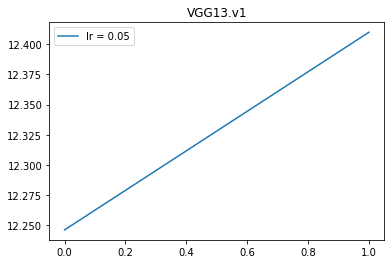

In [83]:
# print graphf
import matplotlib.pyplot as plt
import pickle

#find save dir path
if hyper_param_dict[ 'project'] is not None:
    save_dir = './Result/' + hyper_param_dict[ 'project'] + '/'
else:
    save_dir = './Result/'
dir_list = os.listdir(save_dir)

for dir_name in dir_list:
    if '_' in dir_name:
        load_dir = save_dir + dir_name
        train_acc = np.load(load_dir + '/np_train_acc_list.npy', allow_pickle=True)
        test_acc = np.load(load_dir + '/np_test_acc_list.npy', allow_pickle=True)
        train_loss = np.load(load_dir + '/np_train_loss_list.npy', allow_pickle=True)
        test_loss = np.load(load_dir + '/np_test_loss_list.npy', allow_pickle=True)

        with open( load_dir + '/hyper.pickle', 'rb') as fr:
            hyper_param_load = pickle.load(fr)

        plt.plot(np.arange(0, train_acc.shape[0]), train_acc, label=  'lr = ' + str(hyper_param_load['lr']))
        # plt.legend(str(float(hyper_param_load['lr'])) )
    plt.legend()
    plt.title(hyper_param_dict['project'])
    plt.show()


## GoogLeNet for CIFAR10


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())
    
'''
Step 2:
'''
class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()        

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, padding=3)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=5)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)  # 64 + 128 + 32 + 32 = 256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # N x 3 x 32 x 32
        x = self.conv1(x)
        # N x 64 x 32 x 32
        x = self.conv2(x)
        # N x 64 x 32 x 32
        x = self.conv3(x)
        # N x 192 x 28 x 28

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 10 (num_classes)
        return x

class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, **kwargs),
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)
    


'''
Step 3
'''
model = GoogLeNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=5e-4)

'''
Step 4
'''
model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(100) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()

    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5
'''
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

## GoogLeNet with BatchNorm CIFAR10

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Step 1:
'''
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True, 
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor())
    
'''
Step 2:
'''
class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()        

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, padding=3)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=5)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, **kwargs),
                            nn.BatchNorm2d(out_channels),   #Batch norm here
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)
    


'''
Step 3
'''
model = GoogLeNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=5e-4)

'''
Step 4
'''
model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(100) :
    print("{}th epoch starting.".format(epoch))
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()

    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, train_loss.item()))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


'''
Step 5
'''
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))